# Using word2vec + fully connected neural networks to finish “⾖豆瓣评论” classification

## 1. 加载数据

In [1]:
import pandas as pd
fname = 'movie_comments.csv'
df = pd.read_csv(fname, encoding='utf8')

df.head()

D:\Program\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1


In [2]:
df.shape

(261497, 5)

## 2. 数据预处理

### 2.1检查评分数据

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_star_count(count_star):
    plt.figure(figsize=(12,4))
    sns.barplot(count_star.index, count_star.values, alpha=0.8)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Star', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

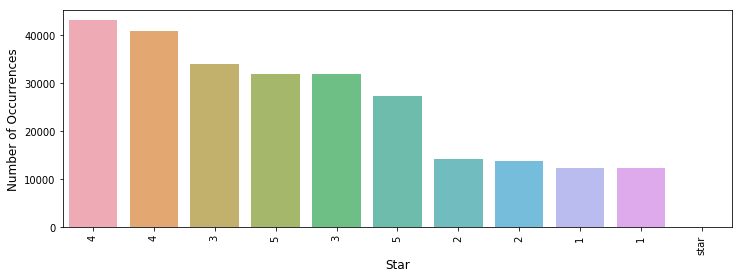

In [4]:
plot_star_count(df['star'].value_counts())

### 2.2 整理评分数据

In [5]:
num_str_list = ['0', '1', '2', '3', '4', '5']
for i in range(len(num_str_list)):
    df.loc[df['star'] == num_str_list[i], 'star'] = i

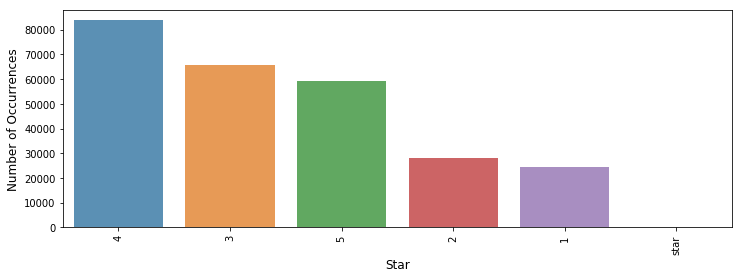

In [6]:
plot_star_count(df['star'].value_counts())

### 2.3 删除comment为空的数据

In [7]:
df = df[pd.notnull(df['comment'])]
df.shape

(261495, 5)

### 2.4 使用jieba对comment分词生成word_tokens

In [8]:
import re
import jieba

def comment_to_word_tokens(comment):
    if not isinstance(comment,str):
        print(comment)
        return
    
    #print(type(comment))
    pattern = re.compile('[\u4E00-\u9FA5]')
    only_chinese = pattern.findall(comment)
    chinese_comment = ''.join(only_chinese)
    chinese_tokens = jieba.cut(chinese_comment)
    word_tokens = ' '.join(chinese_tokens)
    if word_tokens == '':
        return None
    return word_tokens

In [9]:
df['word_tokens'] = df['comment'].apply(comment_to_word_tokens)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DINGLI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.175 seconds.
Prefix dict has been built succesfully.


### 2.5 删除word_tokens 为空的数据

In [10]:
df = df[pd.notnull(df['word_tokens'])]
df.shape

(253336, 6)

### 2.6 重建索引

In [11]:
df.index = range(253336)

## 3. 从词向量到句向量

### 3.1 加载训练好的word2vec 模型

In [12]:
from gensim.models import Word2Vec
zh_wiki_word2vec_model = Word2Vec.load('../lesson04/cbow_word2vec.model')

In [13]:
zh_wiki_word2vec_model.vector_size

200

 ### 3.2 sentence embedding
 
 A Simple but Tough-to-Beat Baseline for Sentence Embeddings
 ref： https://github.com/PrincetonML/SIF

In [14]:
def get_word_frequency(word, model):
    try:
        freq = model.wv.vocab[word].count
    except KeyError:
        freq = 1.0
    return freq

In [15]:
get_word_frequency('意淫', zh_wiki_word2vec_model)

42

In [16]:
def get_word_vector(word, model):
    try:
        vec = model[word]
    except KeyError:
        vec = np.zeros(model.vector_size)
    return vec

In [17]:
get_word_vector('意淫', zh_wiki_word2vec_model)

D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 0.03759095,  0.14011024, -0.14572217,  0.09998303, -0.1325608 ,
        0.13823599,  0.02620292, -0.05573776, -0.1890038 , -0.06985801,
       -0.05942971, -0.3292785 ,  0.23069695, -0.22926018, -0.16528179,
        0.1358727 , -0.06119157,  0.01192596, -0.06293081,  0.04087941,
        0.21568522,  0.19258645,  0.03519976, -0.09244327, -0.05315572,
        0.0529089 , -0.29343638,  0.38297474, -0.22256729, -0.1591071 ,
        0.08015891, -0.21215478,  0.52001214,  0.07766414,  0.20066425,
        0.03186455,  0.16847794, -0.09533515, -0.32239896, -0.02837139,
        0.19097376, -0.00917382,  0.08205621,  0.06451167, -0.2010075 ,
       -0.3093962 , -0.05179121, -0.0081041 , -0.23190635,  0.24018332,
       -0.28461334,  0.31516486, -0.03313563,  0.13341811, -0.3280544 ,
        0.02335869, -0.01769484,  0.03408337, -0.19580963, -0.00157211,
        0.3294343 ,  0.13990225, -0.00827079,  0.2526084 , -0.06284872,
       -0.1058908 ,  0.2987361 ,  0.2231161 ,  0.12316982,  0.22

In [18]:
import numpy as np

In [19]:
def get_sentence_set(sentence_list, word2vec_model, a=1e-3):
    embedding_size = word2vec_model.vector_size
    sentence_set = []
    debug_count = 0
    for sentence in sentence_list:
        vs = np.zeros(embedding_size, dtype=np.float32)  # add all word2vec values into one vector for the sentence
        word_tokens = sentence.split()
        sentence_length = len(word_tokens)
        if sentence_length == 0:
            print(debug_count, )
        for word in word_tokens:
            a_value = a / (a + get_word_frequency(word, word2vec_model))  # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, get_word_vector(word, word2vec_model)))  # vs += sif * word_vector

        vs = np.divide(vs, sentence_length)  # weighted average
        sentence_set.append(vs)  # add to our existing re-calculated set of sentences
        debug_count+=1
    return sentence_set

In [20]:
sentence_set = get_sentence_set(df['word_tokens'], zh_wiki_word2vec_model)

D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
sentence_set[0].dtype

dtype('float32')

In [22]:
from sklearn.decomposition import PCA

In [23]:
def sentence_to_vec(sentence_set, embedding_size):
    # calculate PCA of this sentence set
    pca = PCA(n_components=embedding_size)
    pca.fit(np.array(sentence_set))
    u = pca.components_[0]  # the PCA vector
    u = np.multiply(u, np.transpose(u))  # u x uT

    # pad the vector?  (occurs if we have less sentences than embeddings_size)
    if len(u) < embedding_size:
        for i in range(embedding_size - len(u)):
            u = np.append(u, 0)  # add needed extension for multiplication below

    # resulting sentence vectors, vs = vs -u x uT x vs
    sentence_vecs = []
    for vs in sentence_set:
        sub = np.multiply(u, vs)
        sentence_vecs.append(np.subtract(vs, sub).astype(np.float32))

    return sentence_vecs

In [24]:
sentence_vectors = sentence_to_vec(sentence_set, zh_wiki_word2vec_model.vector_size)

In [25]:
type(sentence_vectors)

list

In [26]:
sentence_vectors[0].dtype

dtype('float32')

In [27]:
X = np.array(sentence_vectors)

In [28]:
X[0].dtype

dtype('float32')

In [29]:
y = df['star'].values

In [30]:
type(y)

numpy.ndarray

##  4.Train neaual network model

## 4.1 按比例70 15 15 划分训练集，验证集，测试集

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test_validation, y_train, y_test_validation = train_test_split(X, y, test_size=0.30, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_test_validation, y_test_validation, test_size=0.5, random_state=42)

### 4.2 构建tf graph

In [32]:
train_dataset = X_train
valid_dataset = X_validation
test_dataset = X_test
train_labels = y_train
valid_labels = y_validation
test_labels = y_test

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (177335, 200) (177335,)
Validation set (38001, 200) (38001,)
Test set (38000, 200) (38000,)


In [33]:
train_labels[0]

5

In [34]:
train_dataset[0]

array([-1.47236214e-08, -1.06214600e-07, -4.90012475e-08,  8.31661637e-08,
       -3.91347861e-08,  1.24595744e-07, -4.05309031e-08, -1.20829098e-08,
       -1.02605014e-07, -1.01182117e-07, -1.06042911e-07, -8.58911431e-09,
        2.37653186e-08, -7.98649964e-08,  1.26428601e-08, -5.93629501e-08,
        1.56406021e-09,  5.12848572e-08, -1.30821874e-07,  3.93744806e-08,
       -5.47622792e-09, -7.06731740e-09, -3.61116470e-08,  5.53322970e-08,
       -6.52493739e-08,  1.46025574e-08, -8.93369112e-09,  8.60639702e-08,
        7.26041733e-08, -5.51157875e-08,  5.39559544e-08, -1.02661105e-07,
        1.04828388e-07, -7.12494241e-08, -1.71503316e-07,  1.62460509e-07,
        6.13562534e-08,  8.12724537e-08,  9.95911265e-08,  6.26399199e-08,
       -3.33785302e-08,  2.71472378e-09, -3.84677179e-08,  2.04678940e-08,
       -1.34561811e-08, -6.58265975e-08, -9.87888313e-08, -1.33530254e-08,
        9.14442282e-08, -1.37258809e-07,  1.43942771e-07,  3.63106665e-08,
       -8.95071572e-09,  

In [35]:
embedding_size = zh_wiki_word2vec_model.vector_size
num_labels = 5

In [36]:
def reformat(labels):
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return labels
train_labels = reformat(train_labels)
valid_labels = reformat(valid_labels)
test_labels = reformat(test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (177335, 200) (177335, 5)
Validation set (38001, 200) (38001, 5)
Test set (38000, 200) (38000, 5)


In [37]:
import tensorflow as tf

In [38]:

num_nodes= 1024
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, embedding_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([embedding_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation 
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    test_prediction = tf.nn.softmax(logits_2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [39]:
num_steps = 10001

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}%".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {:.1f}%".format(accuracy(test_prediction.eval(), test_labels)))

Initialized
Minibatch loss at step 0: 1.282533884048462
Minibatch accuracy: 21.9%
Validation accuracy: 32.2%
Minibatch loss at step 500: 9471996928.0
Minibatch accuracy: 9.4%
Validation accuracy: 24.8%
Minibatch loss at step 1000: 5.812248922061118e+19
Minibatch accuracy: 25.0%
Validation accuracy: 32.2%
Minibatch loss at step 1500: 2.9494533454670365e+29
Minibatch accuracy: 10.9%
Validation accuracy: 32.2%
Minibatch loss at step 2000: nan
Minibatch accuracy: 21.1%
Validation accuracy: 22.5%
Minibatch loss at step 2500: nan
Minibatch accuracy: 28.1%
Validation accuracy: 22.5%
Minibatch loss at step 3000: nan
Minibatch accuracy: 17.2%
Validation accuracy: 22.5%
Minibatch loss at step 3500: nan
Minibatch accuracy: 18.0%
Validation accuracy: 22.5%
Minibatch loss at step 4000: nan
Minibatch accuracy: 22.7%
Validation accuracy: 22.5%
Minibatch loss at step 4500: nan
Minibatch accuracy: 25.8%
Validation accuracy: 22.5%
Minibatch loss at step 5000: nan
Minibatch accuracy: 29.7%
Validation acc